In [42]:
#!pip install datasets
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 9.3 MB/s eta 0:00:00


In [43]:
import datasets
import faiss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from typing import Callable, Iterable

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

Device: cpu


# Dataset preparation

In [5]:
# Диалоги в csv разделены пустой строкой
data = pd.read_csv('/content/drive/MyDrive/models/simpsons_dataset.csv')
data.head(10)

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...
5,Martin Prince,I don't think there's anything left to say.
6,Edna Krabappel-Flanders,Bart?
7,Bart Simpson,Victory party under the slide!
8,NaN,NaN
9,Lisa Simpson,Mr. Bergstrom! Mr. Bergstrom!


In [6]:
i = 0
context = list()
dataset = list()
for idx, row in data.iterrows():
  charachter, phrase = row['raw_character_text'], row['spoken_words']
  if not isinstance(charachter, str):
    context = list()
  elif len(context)>0:
    item = {
        'prompt': context[-1],
        'response': 'UNK' if not isinstance(phrase, str) else phrase,
        'context': context[:-2] if len(context) < 10 else context[-10 :-2],
        'label': 1 if charachter == 'Homer Simpson' else 0
    }
    dataset.append(item)
    context.append('UNK' if not isinstance(phrase, str) else phrase)
  else:
    context.append('UNK' if not isinstance(phrase, str) else phrase)

In [6]:
len(dataset)

124681

In [7]:
for i in range(20):
  print(dataset[i])

{'prompt': "No, actually, it was a little of both. Sometimes when a disease is in all the magazines and all the news shows, it's only natural that you think you have it.", 'response': "Where's Mr. Bergstrom?", 'context': [], 'label': 0}
{'prompt': "Where's Mr. Bergstrom?", 'response': "I don't know. Although I'd sure like to talk to him. He didn't touch my lesson plan. What did he teach you?", 'context': [], 'label': 0}
{'prompt': "I don't know. Although I'd sure like to talk to him. He didn't touch my lesson plan. What did he teach you?", 'response': 'That life is worth living.', 'context': ["No, actually, it was a little of both. Sometimes when a disease is in all the magazines and all the news shows, it's only natural that you think you have it."], 'label': 0}
{'prompt': 'That life is worth living.', 'response': "The polls will be open from now until the end of recess. Now, just in case any of you have decided to put any thought into this, we'll have our final statements. Martin?", 

# Custom Dataset

In [8]:
seed = 10

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [9]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
#%%time

MAX_LENGTH = 128

tokenized_prompts = tokenizer([data["prompt"] for data in dataset],
                              max_length=MAX_LENGTH,
                              padding="max_length",
                              truncation=True,
                              verbose=True
                              )

tokenized_responses = tokenizer([data["response"] for data in dataset],
                                max_length=MAX_LENGTH,
                                padding="max_length",
                                truncation=True,
                                verbose=True
                                )

In [12]:
print(len(tokenized_responses), len(tokenized_responses[0]), len(tokenized_responses[1]))
print(len(tokenized_prompts), len(tokenized_prompts[0]), len(tokenized_prompts[1]))

2 128 128
2 128 128


In [13]:
tokenized_responses[1].tokens[127]

'[PAD]'

In [14]:
len(tokenized_responses["input_ids"])

124681

In [15]:
tokenizer.decode(tokenized_responses["input_ids"][10])

'[CLS] the train, how like him... traditional, yet environmentally sound. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [16]:
tokenizer.decode(tokenized_prompts["input_ids"][20])

'[CLS] somebody must have voted. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [11]:
class HomerDataset(Dataset):
      def __init__(self, prompt_tokens: dict, response_tokens: dict, labels: Iterable[str]): # На входе токенезированные реплики и ответы + разметка (ответ Гомера 1, остальное - 0)
          self.prompt_tokens = prompt_tokens
          self.response_tokens = response_tokens
          self.labels = labels
          self._init_data()

      def _init_data(self) -> None:
          self.data = []
          for pt_ids, pt_am, rt_ids, rt_am, label in zip(
              self.prompt_tokens["input_ids"],
              self.prompt_tokens["attention_mask"],
              self.response_tokens["input_ids"],
              self.response_tokens["attention_mask"],
              self.labels
          ):
              data = {}
              data["prompt_input_ids"]  = torch.tensor(pt_ids, dtype=torch.long)
              data["prompt_attention_mask"] = torch.tensor(pt_am, dtype=torch.long)
              data["response_input_ids"] = torch.tensor(rt_ids, dtype=torch.long)
              data["response_attention_mask"] = torch.tensor(rt_am, dtype=torch.long)
              data["label"] = torch.tensor(label, dtype=torch.long) # метка класса
              self.data.append(data)

      def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
          return self.data[ix]

      def __len__(self) -> int:
          return len(self.data)

In [12]:
# Инициализируем датасет
homer_dataset = HomerDataset(tokenized_prompts, tokenized_responses, (data["label"] for data in dataset))

In [12]:
# разбиение на трейн и тест
train_ratio = 0.8
n_total = len(homer_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(homer_dataset, [n_train, n_val])

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# BI-Encoder

In [13]:
def mean_pool(token_embeds: torch.tensor, attention_mask: torch.tensor) -> torch.tensor:
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
    return pool
    # Пулинг - избавиться от части предсказаний, чтобы они не зашумляли
    # Задача - стабилизировть обучение. Альтернатива - нормализировать на выходе из BERT


def encode(input_texts: list[str], tokenizer: AutoTokenizer, model: AutoModel, device: str = "cpu"
) -> torch.tensor:

    model.eval()
    tokenized_texts = tokenizer(input_texts, max_length=128,
                                padding='max_length', truncation=True, return_tensors="pt")
    token_embeds = model(tokenized_texts["input_ids"].to(device),
                         tokenized_texts["attention_mask"].to(device)).last_hidden_state
    pooled_embeds = mean_pool(token_embeds, tokenized_texts["attention_mask"].to(device))
    return pooled_embeds

In [14]:
class SentenceBert(torch.nn.Module):
    def __init__(self, max_length: int = 128):
        super().__init__()
        self.max_length = max_length
        self.bert_model = AutoModel.from_pretrained('distilbert-base-uncased')
        self.bert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size * 3, 3)

    def forward(self, data: datasets.arrow_dataset.Dataset) -> torch.tensor:
        prompt_input_ids = data["prompt_input_ids"].to(device)
        prompt_attention_mask = data["prompt_attention_mask"].to(device)
        response_input_ids = data["response_input_ids"].to(device)
        response_attention_mask = data["response_attention_mask"].to(device)

        out_prompt = self.bert_model(prompt_input_ids, prompt_attention_mask)
        out_response = self.bert_model(response_input_ids, response_attention_mask)
        prompt_embeds = out_prompt.last_hidden_state
        response_embeds = out_response.last_hidden_state

        pooled_prompt_embeds = mean_pool(prompt_embeds, prompt_attention_mask)
        pooled_response_embeds = mean_pool(response_embeds, response_attention_mask)

        embeds =  torch.cat([pooled_prompt_embeds, pooled_response_embeds,
                             torch.abs(pooled_prompt_embeds - pooled_response_embeds)],
                            dim=-1)
        return self.linear(embeds)

In [15]:
model = SentenceBert().to(device)

In [23]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-6)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.CrossEntropyLoss()

In [24]:
def get_train_step_fn(
    model: torch.nn.Module, optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.LambdaLR, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor, torch.tensor], float]:

    def train_step_fn(x: torch.tensor, y: torch.tensor) -> float:
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        return loss.item()

    return train_step_fn


def get_val_step_fn(
    model: torch.nn.Module, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor, torch.tensor], float]:

    def val_step_fn(x: torch.tensor, y: torch.tensor) -> float:
        model.eval()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        return loss.item()

    return val_step_fn


def mini_batch(
    dataloader: DataLoader,
    step_fn: Callable[[torch.tensor, torch.tensor], float],
    is_training: bool = True
) -> tuple[np.array, list[float]]:

    mini_batch_losses = []

    if is_training:
        print("\nTraining ...")
    else:
        print("\nValidating ...")
    n_steps = len(dataloader)
    for i, data in enumerate(dataloader):
        loss = step_fn(data, data["label"].to(device))
        mini_batch_losses.append(loss)
        if i % (batch_size * 100) == 0:
            print(f"step {i:>5}/{n_steps}, loss = {loss: .3f}")

    return np.mean(mini_batch_losses), mini_batch_losses

In [25]:
%%time

n_epochs = 1  # mentioned in the paper

train_step_fn = get_train_step_fn(model, optimizer, scheduler, loss_fn)
val_step_fn = get_val_step_fn(model, loss_fn)

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn)
    train_mini_batch_losses += _train_mini_batch_losses
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses += _val_mini_batch_losses
        val_losses.append(val_loss)


Training ...
step     0/6234, loss =  1.222
step  1600/6234, loss =  0.458
step  3200/6234, loss =  0.461
step  4800/6234, loss =  0.535

Validating ...
step     0/1559, loss =  0.485
CPU times: user 37min 19s, sys: 40 s, total: 37min 59s
Wall time: 38min 12s


In [26]:
len(train_mini_batch_losses)

6234

In [27]:
train_losses

[0.5227436344302118]

In [28]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

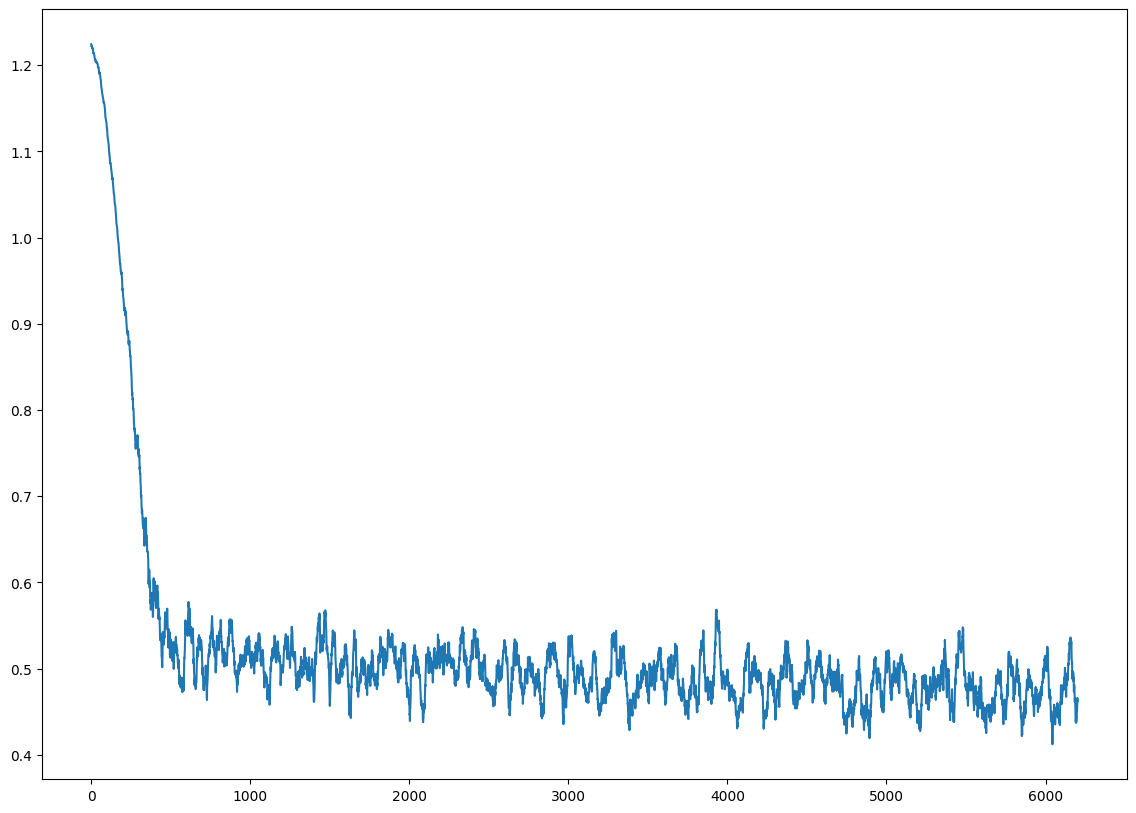

In [30]:
fix, ax = plt.subplots(figsize=(14, 10))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

In [ ]:
#model.bert_model.save_pretrained("/content/drive/MyDrive/models/sentence_bert_softmax_lr_2e-6")

In [16]:
model.bert_model.from_pretrained("/content/drive/MyDrive/models/sentence_bert_softmax_lr_2e-6")

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [100]:
model

SentenceBert(
  (bert_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Line

In [18]:
sentences = [data['prompt'] for data in dataset][:50]

In [ ]:
pooled_embeds = encode(sentences, model.bert_tokenizer, model.bert_model, 'cpu')
pooled_embeds = pooled_embeds.cpu().detach().numpy()

In [37]:
def plot_heatmap(similarity_matrix: np.array, sentences: list[str]) -> None:
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(similarity_matrix, cmap='YlGn', interpolation='nearest')

    ax.set_yticks(np.arange(len(sentences)), labels=[txt[:50] + "..." for txt in sentences])
    ax.set_xticks(np.arange(len(sentences)), labels=[txt[:50] + "..." for txt in sentences])

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(sentences)):
        for j in range(len(sentences)):
            text = ax.text(j, i, round(similarity_matrix[i, j], 2),
                           ha="center", va="center", color="w")

    fig.tight_layout()
    plt.show()

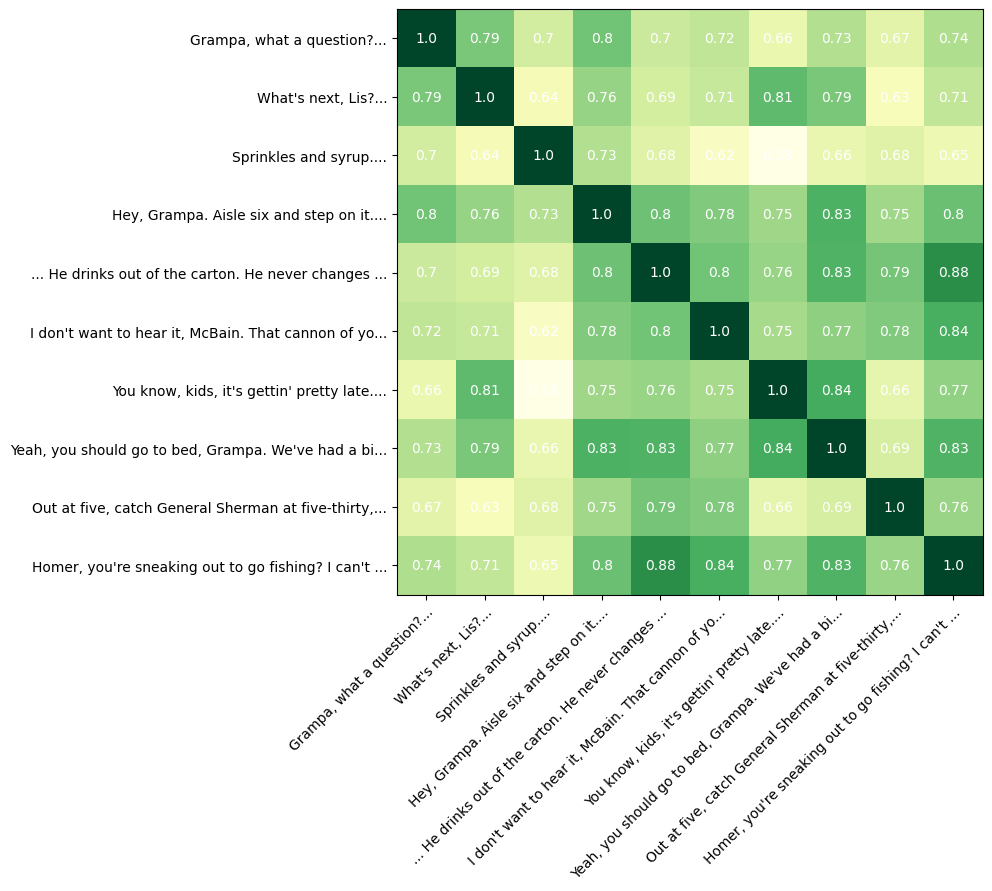

In [47]:
similarity_matrix = cosine_similarity(pooled_embeds[40:50])
plot_heatmap(similarity_matrix, sentences[40:50])

In [48]:
sentences[40:50]

['Grampa, what a question?',
 "What's next, Lis?",
 'Sprinkles and syrup.',
 'Hey, Grampa. Aisle six and step on it.',
 "... He drinks out of the carton. He never changes the baby. When he goes to sleep, he makes chewing noises and when he wakes up he makes honking noises. Oh... oh... and he scratches himself with his keys. I guess that's it. Oh no. Wait. He kicks me in his sleep and his toenails are too long and yellow. That's all I can think of right now. I guess you're all tired and I want to thank you for letting me get some things off my chest.",
 "I don't want to hear it, McBain. That cannon of yours is against regulations. In this department we go by the book.",
 "You know, kids, it's gettin' pretty late.",
 "Yeah, you should go to bed, Grampa. We've had a big day.",
 'Out at five, catch General Sherman at five-thirty, clean him at six, eat him at six-thirty, back in bed by seven with no incriminating evidence. . The perfect crime.',
 "Homer, you're sneaking out to go fishing? I

# Faiss to find response-candidates

In [32]:
def embed_bert_cls(text: str, model, tokenizer) -> np.array:
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

print(embed_bert_cls('привет мир', model.bert_model, model.bert_tokenizer).shape)

(768,)


In [36]:
base = np.array([embed_bert_cls(data['response'], model.bert_model, model.bert_tokenizer) for data in tqdm(dataset)])

  0%|          | 0/124681 [00:00<?, ?it/s]

In [37]:
np.save('/content/drive/MyDrive/models/base.npy', base)    # .npy extension is added if not given
#base = np.load('/content/drive/MyDrive/models/base.npy')

In [44]:
index = faiss.IndexFlatL2(base.shape[1])

In [45]:
index.add(base)

In [106]:
k = 4
query = 'Homer, do you have any plans for a weekend?'
# xq = embed_bert_cls(query, model.bert_model, model.bert_tokenizer)
# xq.shape
pooled_embeds = encode([query], model.bert_tokenizer, model.bert_model, 'cpu')
pooled_embeds = pooled_embeds.cpu().detach().numpy()

In [107]:
%%time
#D, I = index.search(xq.reshape(1, 768), 10)  # search
D, I = index.search(pooled_embeds, 10)
print(I)

[[ 93845  91877   2847  24168  96742  46333 122470 113586  70330  94552]]
CPU times: user 54.5 ms, sys: 1.99 ms, total: 56.5 ms
Wall time: 58 ms


In [108]:
for i in I[0]:
  print(dataset[i]['response'])

Tour the historic Civil War prison, and picnic where the bodies were once stacked like cordwood.
Homeroom, eight a.m.
Homer, meet Dave Jr.
Homie, it's 4:30 in the morning. "Little Rascals" isn't on 'til 6.
Triple spring break plus four weeks at Christmas.
A BOOK ABOUT A MAN A BOOK ABOUT THE DUDE WHO LIVES ABOVE A BOOK ABOUT A MAN WHO DRIVES A PICKUP FULL OF SWEET, SWEET LOVE.
Homer, would you like some more macaroni and cheese?
Homer look what someone left in the kitchen. Frosty chocolate milkshakes.
Aunt Patty, where did you two meet? Alternative book store? Ethiopian restaurant?
Dancing and sculpting...


In [57]:
dataset[18887]

{'prompt': 'My house is on fire! Woo hoo! Insurance to the rescue.',
 'response': 'Hello, Homer.',
 'context': [],
 'label': 0}

# Cross-Encoder to rerank candidates

In [33]:
# (549367,
#  {'premise': 'A person on a horse jumps over a broken down airplane.',
#   'hypothesis': 'A person is training his horse for a competition.',
#   'label': 1})

In [34]:
# {'prompt': вопрос, 'responce': ответ, 'context:[[для, хранения], [предыдущего, диалога], [до 8, реплик]]'}